### IMDB Rating Prediction

In [1]:
#importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error
warnings.filterwarnings("ignore")

In [2]:
movies =  pd.read_csv("C://Users//ksheeras//Downloads//movie_metadata.csv")

In [3]:
movies.head(5)

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [4]:
movies.shape

(5043, 28)

In [5]:
#checking for missing values and imbalanced data
nans = []
pcts = []
Catg = []
unique = []
catg_values = []
for cols in movies:
    nans.append(movies[cols].isnull().sum())
    pcts.append(movies[cols].isnull().sum()/movies.shape[0]*100)
    Catg.append(movies[cols].dtype)
    unique.append(movies[cols].nunique())
    catg_values.append(movies[cols].value_counts(normalize=True, dropna=False).values[0] * 100)

In [6]:
missing_data = pd.DataFrame({"Col":movies.columns,"Unique Values" :unique , "Missing values": nans,
"Pct missing [%]": pcts,"% of points in the biggest category" : catg_values , "Category" : Catg}).sort_values("% of points in the biggest category", ascending=False)
missing_data[missing_data["Missing values"]!=0].reset_index(drop=True)

,Col,Unique Values,Missing values,Pct missing [%],% of points in the biggest category,Category
0,color,2,19,0.376760,95.478882,object
1,language,47,12,0.237954,93.277811,object
2,country,65,5,0.099147,75.490779,object
3,aspect_ratio,22,329,6.523895,46.797541,float64
4,facenumber_in_poster,19,13,0.257783,42.673012,float64
5,content_rating,18,303,6.008328,41.998810,object
6,director_facebook_likes,435,104,2.062265,17.985326,float64
7,gross,4035,884,17.529248,17.529248,float64
8,budget,439,492,9.756098,9.756098,float64
9,actor_1_facebook_likes,878,7,0.138806,8.903430,float64


In [7]:
#drop columns which have high percentage of points in one category i.e color and language
movies.drop(['color'] , inplace=True, axis=1)
movies.drop(['language'] , inplace=True, axis=1)

In [8]:
movies.drop(['movie_imdb_link'] , inplace=True, axis=1)

In [9]:
movies.describe()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
count,4993.000000,5028.000000,4939.000000,5020.000000,5036.000000,4.159000e+03,5.043000e+03,5043.000000,5030.000000,5022.000000,4.551000e+03,4935.000000,5030.000000,5043.000000,4714.000000,5043.000000
mean,140.194272,107.201074,686.509212,645.009761,6560.047061,4.846841e+07,8.366816e+04,9699.063851,1.371173,272.770808,3.975262e+07,2002.470517,1651.754473,6.442138,2.220403,7525.964505
std,121.601675,25.197441,2813.328607,1665.041728,15020.759120,6.845299e+07,1.384853e+05,18163.799124,2.013576,377.982886,2.061149e+08,12.474599,4042.438863,1.125116,1.385113,19320.445110
min,1.000000,7.000000,0.000000,0.000000,0.000000,1.620000e+02,5.000000e+00,0.000000,0.000000,1.000000,2.180000e+02,1916.000000,0.000000,1.600000,1.180000,0.000000
25%,50.000000,93.000000,7.000000,133.000000,614.000000,5.340988e+06,8.593500e+03,1411.000000,0.000000,65.000000,6.000000e+06,1999.000000,281.000000,5.800000,1.850000,0.000000
50%,110.000000,103.000000,49.000000,371.500000,988.000000,2.551750e+07,3.435900e+04,3090.000000,1.000000,156.000000,2.000000e+07,2005.000000,595.000000,6.600000,2.350000,166.000000
75%,195.000000,118.000000,194.500000,636.000000,11000.000000,6.230944e+07,9.630900e+04,13756.500000,2.000000,326.000000,4.500000e+07,2011.000000,918.000000,7.200000,2.350000,3000.000000
max,813.000000,511.000000,23000.000000,23000.000000,640000.000000,7.605058e+08,1.689764e+06,656730.000000,43.000000,5060.000000,1.221550e+10,2016.000000,137000.000000,9.500000,16.000000,349000.000000


In [10]:
#checcking for outliers in the target variable
for i in range(0,100,10):
    var =movies["imdb_score"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is 1.6
10 percentile value is 5.0
20 percentile value is 5.6
30 percentile value is 6.0
40 percentile value is 6.3
50 percentile value is 6.6
60 percentile value is 6.8
70 percentile value is 7.1
80 percentile value is 7.4
90 percentile value is 7.8
100 percentile value is  9.5


In [11]:
movies.head()

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,...,plot_keywords,num_user_for_reviews,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,...,avatar|future|marine|native|paraplegic,3054.0,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,...,goddess|marriage ceremony|marriage proposal|pi...,1238.0,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,...,bomb|espionage|sequel|spy|terrorist,994.0,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,...,deception|imprisonment|lawlessness|police offi...,2701.0,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,Doug Walker,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


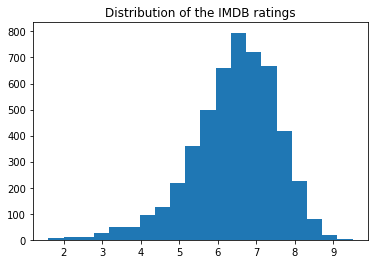

In [12]:
#checking for distribution of the target variable
%matplotlib inline
labels=movies["imdb_score"]
import matplotlib.pyplot as plt
font = {'fontname':'Arial', 'size':'14'}
title_font = { 'weight' : 'bold','size':'16'}
plt.hist(labels, bins=20)
plt.title("Distribution of the IMDB ratings")
plt.show()

In [13]:
dtypes = movies.dtypes.astype(str).to_dict()

In [14]:
movies.drop(['movie_title'] , inplace=True, axis=1)

In [15]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_columns = [c for c,v in dtypes.items() if v in numerics]
binary_variables = [c for c in movies.columns if movies[c].nunique() == 2]
categorical_columns = [c for c in movies.columns if (c not in numerical_columns) & (c not in binary_variables)]

In [16]:
movies_n = movies[numerical_columns]

In [17]:
#computing the correlation matrix of the numerical features with that of the target varible
corr_matrix = movies_n.corr()
corr_matrix['imdb_score'].sort_values(ascending = False)

imdb_score                   1.000000
num_voted_users              0.410965
num_critic_for_reviews       0.305303
num_user_for_reviews         0.292475
duration                     0.261662
movie_facebook_likes         0.247049
gross                        0.198021
director_facebook_likes      0.170802
cast_total_facebook_likes    0.085787
actor_2_facebook_likes       0.083808
actor_1_facebook_likes       0.076099
aspect_ratio                 0.059445
actor_3_facebook_likes       0.052633
budget                       0.030688
facenumber_in_poster        -0.062958
title_year                  -0.209167
Name: imdb_score, dtype: float64

In [18]:
#drop face number as its not very correlated with target
movies.drop(['facenumber_in_poster'] , inplace=True, axis=1)

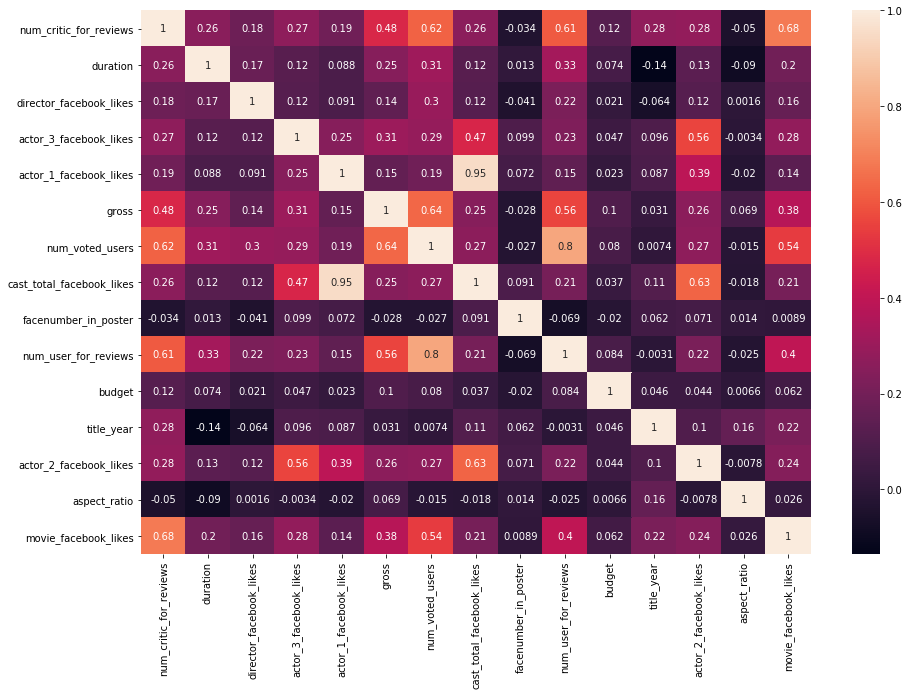

In [19]:
#plotting a heatmap to check how to variables are correlated amongst themselves so that we can drop columns with redundant information
import seaborn as sns
cols_to_use = [i for i in movies_n.columns if i != 'imdb_score' ]
plt.figure(figsize=(15,10))
sns.heatmap(movies_n[cols_to_use].corr(), annot = True);

cast_total_facebook_likes and actor_1_facebook_likes are highly corraleted to each other, which would give redundant information, so one of them can be dropped. Likewise, num_of_voted_users and num_user_for_reviews are also highly corellated. So one could be dropped.

In [20]:
#movies.drop(['cast_total_facebook_likes'] , inplace=True, axis=1)
movies.drop(['num_user_for_reviews'] , inplace=True, axis=1)

In [21]:
movies.columns

Index(['director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'num_voted_users', 'cast_total_facebook_likes', 'actor_3_name',
       'plot_keywords', 'country', 'content_rating', 'budget', 'title_year',
       'actor_2_facebook_likes', 'imdb_score', 'aspect_ratio',
       'movie_facebook_likes'],
      dtype='object')

In [22]:
print(categorical_columns)

['director_name', 'actor_2_name', 'genres', 'actor_1_name', 'actor_3_name', 'plot_keywords', 'country', 'content_rating']


In [23]:
movies.head()

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,...,actor_3_name,plot_keywords,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,...,Wes Studi,avatar|future|marine|native|paraplegic,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,...,Jack Davenport,goddess|marriage ceremony|marriage proposal|pi...,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,...,Stephanie Sigman,bomb|espionage|sequel|spy|terrorist,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,...,Joseph Gordon-Levitt,deception|imprisonment|lawlessness|police offi...,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,Doug Walker,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [24]:
from sklearn.model_selection import train_test_split
y = movies['imdb_score']
movies.drop(['imdb_score'] , inplace=True, axis=1)

In [25]:
movies["plot_keywords"]=movies["plot_keywords"].fillna("None")

In [26]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for i in categorical_columns:
    if i not in ['plot_keywords' , 'genres']:
        movies[i]=movies[i].fillna("None")
        movies[i] = le.fit_transform(movies[i])

In [27]:
movies.head()

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,...,cast_total_facebook_likes,actor_3_name,plot_keywords,country,content_rating,budget,title_year,actor_2_facebook_likes,aspect_ratio,movie_facebook_likes
0,922,723.0,178.0,0.0,855.0,1405,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,264,...,4834,3438,avatar|future|marine|native|paraplegic,63,8,237000000.0,2009.0,936.0,1.78,33000
1,794,302.0,169.0,563.0,1000.0,2217,40000.0,309404152.0,Action|Adventure|Fantasy,976,...,48350,1390,goddess|marriage ceremony|marriage proposal|pi...,63,8,300000000.0,2007.0,5000.0,2.35,0
2,2022,602.0,148.0,0.0,161.0,2488,11000.0,200074175.0,Action|Adventure|Thriller,349,...,11700,3130,bomb|espionage|sequel|spy|terrorist,62,8,245000000.0,2015.0,393.0,2.35,85000
3,373,813.0,164.0,22000.0,23000.0,532,27000.0,448130642.0,Action|Thriller,1964,...,106759,1763,deception|imprisonment|lawlessness|police offi...,63,8,250000000.0,2012.0,23000.0,2.35,164000
4,600,NaN,NaN,131.0,NaN,2432,131.0,NaN,Documentary,522,...,143,2551,None,41,5,NaN,NaN,12.0,NaN,0


In [28]:
#splitting data into test and train
X = movies
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [29]:
X_train.shape

(3378, 21)

In [30]:
#vectorizing the categorical features using tfidf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def token(text):
    return(text.split("|"))

tfidf_plot =  TfidfVectorizer(tokenizer=token , max_features = 2000)
tfidf_plot_features_train = tfidf_plot.fit_transform(X_train['plot_keywords'])
tfidf_plot_features_test = tfidf_plot.transform(X_test['plot_keywords'])

In [31]:
X_train.drop(['plot_keywords'] , inplace=True, axis=1)
X_test.drop(['plot_keywords'] , inplace=True, axis=1)

In [32]:
tfidf_plot =  TfidfVectorizer(tokenizer=token , max_features = 2000 )
tfidf_genre_features_train = tfidf_plot.fit_transform(X_train['genres'])
tfidf_genre_features_test = tfidf_plot.transform(X_test['genres'])
#genre = pd.SparseDataFrame(tfidf_plot.fit_transform(X_train['genres']),columns=tfidf_plot.get_feature_names(), default_fill_value=0)

In [33]:
X_train.drop(['genres'] , inplace=True, axis=1)
X_test.drop(['genres'] , inplace=True, axis=1)

In [34]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [35]:
tfidf_genre_features_train = tfidf_genre_features_train.toarray()
tfidf_genre_features_test = tfidf_genre_features_test.toarray()
tfidf_plot_features_train = tfidf_plot_features_train.toarray()
tfidf_plot_features_test = tfidf_plot_features_test.toarray()

In [36]:
tfidf_genre_features_train = np.array(tfidf_genre_features_train)
tfidf_genre_features_test = np.array(tfidf_genre_features_test)
tfidf_plot_features_train = np.array(tfidf_plot_features_train)
tfidf_plot_features_test = np.array(tfidf_plot_features_test)

In [37]:
tfidf_plot_features_test.shape

(1665, 2000)

In [38]:
X_train = np.column_stack((X_train,tfidf_plot_features_train,tfidf_genre_features_train))
X_test = np.column_stack((X_test,tfidf_plot_features_test,tfidf_genre_features_test))

In [39]:
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)
y_train = np.nan_to_num(y_train)

In [40]:
#Standardizing the data
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

### Machine Learning Model

### Lasso regression

In [87]:

from sklearn.model_selection import GridSearchCV

alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000]
error = {}
for i in alpha:
    rgr_lasso = Lasso(alpha = i)
    rgr_lasso.fit(X_train,y_train)
    y_pred = rgr_lasso.predict(X_test)
    mse = mean_absolute_error(y_test, y_pred)
    error[i] = mse

In [88]:
print(error)

{0.0001: 0.9486631994848361, 0.001: 0.8678153964178955, 0.01: 0.6827711450953269, 0.1: 0.7128259583169101, 1: 0.877505213917292, 10: 0.877505213917292, 100: 0.877505213917292, 1000: 0.877505213917292}


In [89]:
from sklearn.metrics import mean_absolute_error
rgr_lasso = Lasso(alpha = 0.01)
rgr_lasso.fit(X_train,y_train)
y_pred = rgr_lasso.predict(X_test)
mse = mean_absolute_error(y_test, y_pred)
print(mse)

0.6827711450953269


### Tree Based Models

In [95]:
#Applying simple Decision Tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
max_depth = [3,6,9,12]
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
max_features = list(range(1,X_train.shape[1]))
parameters = {'max_depth' : max_depth , 'min_samples_split' : min_samples_splits , 'min_samples_leaf' : min_samples_leafs , 'max_features' : max_features }
clf = DecisionTreeRegressor(random_state=0)
Tree = RandomizedSearchCV(clf,param_distributions = parameters, scoring = 'neg_mean_squared_error' , cv = 3 , verbose = 10)
Tree.fit(X_train,y_train)

print(Tree.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] min_samples_split=1.0, min_samples_leaf=0.2, max_features=1665, max_depth=3 
[CV]  min_samples_split=1.0, min_samples_leaf=0.2, max_features=1665, max_depth=3, score=-1.0258192016481464, total=   0.0s
[CV] min_samples_split=1.0, min_samples_leaf=0.2, max_features=1665, max_depth=3 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV]  min_samples_split=1.0, min_samples_leaf=0.2, max_features=1665, max_depth=3, score=-1.0887848075448372, total=   0.0s
[CV] min_samples_split=1.0, min_samples_leaf=0.2, max_features=1665, max_depth=3 
[CV]  min_samples_split=1.0, min_samples_leaf=0.2, max_features=1665, max_depth=3, score=-1.147825688039454, total=   0.0s
[CV] min_samples_split=0.1, min_samples_leaf=0.1, max_features=1617, max_depth=12 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


[CV]  min_samples_split=0.1, min_samples_leaf=0.1, max_features=1617, max_depth=12, score=-0.8602928104821795, total=   0.1s
[CV] min_samples_split=0.1, min_samples_leaf=0.1, max_features=1617, max_depth=12 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s


[CV]  min_samples_split=0.1, min_samples_leaf=0.1, max_features=1617, max_depth=12, score=-0.8600691965704598, total=   0.1s
[CV] min_samples_split=0.1, min_samples_leaf=0.1, max_features=1617, max_depth=12 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s


[CV]  min_samples_split=0.1, min_samples_leaf=0.1, max_features=1617, max_depth=12, score=-0.9665301009967509, total=   0.1s
[CV] min_samples_split=0.7000000000000001, min_samples_leaf=0.2, max_features=99, max_depth=6 
[CV]  min_samples_split=0.7000000000000001, min_samples_leaf=0.2, max_features=99, max_depth=6, score=-1.2201551886777566, total=   0.0s
[CV] min_samples_split=0.7000000000000001, min_samples_leaf=0.2, max_features=99, max_depth=6 
[CV]  min_samples_split=0.7000000000000001, min_samples_leaf=0.2, max_features=99, max_depth=6, score=-1.2478124615498676, total=   0.0s

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.1s remaining:    0.0s



[CV] min_samples_split=0.7000000000000001, min_samples_leaf=0.2, max_features=99, max_depth=6 
[CV]  min_samples_split=0.7000000000000001, min_samples_leaf=0.2, max_features=99, max_depth=6, score=-1.2785618408267054, total=   0.0s
[CV] min_samples_split=0.6, min_samples_leaf=0.30000000000000004, max_features=99, max_depth=3 
[CV]  min_samples_split=0.6, min_samples_leaf=0.30000000000000004, max_features=99, max_depth=3, score=-1.2201551886777566, total=   0.0s
[CV] min_samples_split=0.6, min_samples_leaf=0.30000000000000004, max_features=99, max_depth=3 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.3s remaining:    0.0s


[CV]  min_samples_split=0.6, min_samples_leaf=0.30000000000000004, max_features=99, max_depth=3, score=-1.2478124615498676, total=   0.0s
[CV] min_samples_split=0.6, min_samples_leaf=0.30000000000000004, max_features=99, max_depth=3 
[CV]  min_samples_split=0.6, min_samples_leaf=0.30000000000000004, max_features=99, max_depth=3, score=-1.2785618408267054, total=   0.0s
[CV] min_samples_split=0.1, min_samples_leaf=0.2, max_features=1885, max_depth=6 
[CV]  min_samples_split=0.1, min_samples_leaf=0.2, max_features=1885, max_depth=6, score=-0.9095090226757445, total=   0.1s
[CV] min_samples_split=0.1, min_samples_leaf=0.2, max_features=1885, max_depth=6 
[CV]  min_samples_split=0.1, min_samples_leaf=0.2, max_features=1885, max_depth=6, score=-0.9567582273822209, total=   0.1s
[CV] min_samples_split=0.1, min_samples_leaf=0.2, max_features=1885, max_depth=6 
[CV]  min_samples_split=0.1, min_samples_leaf=0.2, max_features=1885, max_depth=6, score=-1.0065175800465804, total=   0.1s
[CV] min_s

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    4.8s finished


{'min_samples_split': 0.2, 'min_samples_leaf': 0.1, 'max_features': 1833, 'max_depth': 6}


In [96]:

clf = DecisionTreeRegressor(min_samples_split =  0.2, min_samples_leaf =  0.1 , max_features = 1833, max_depth = 6)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
mse = mean_absolute_error(y_test, y_pred)
print(mse)

0.7333405516294562


### Random Forest Model

In [100]:
from sklearn.ensemble import RandomForestRegressor
n_estimators = [50,100,150,200,250]
max_depth = [3,6,9,12,15]
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
max_features = list(range(1,X_train.shape[1]))
clf = RandomForestRegressor(random_state=0)
parameters = {'n_estimators' : n_estimators , 'max_depth' : max_depth , 'min_samples_split' : min_samples_splits , 'min_samples_leaf' : min_samples_leafs , 'max_features' : max_features }
Tree = RandomizedSearchCV(clf,param_distributions = parameters, scoring = 'neg_mean_squared_error' , cv = 3 , verbose = 10)
Tree.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=200, min_samples_split=0.9, min_samples_leaf=0.1, max_features=304, max_depth=3 
[CV]  n_estimators=200, min_samples_split=0.9, min_samples_leaf=0.1, max_features=304, max_depth=3, score=-1.2203959909735353, total=   0.2s
[CV] n_estimators=200, min_samples_split=0.9, min_samples_leaf=0.1, max_features=304, max_depth=3 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  n_estimators=200, min_samples_split=0.9, min_samples_leaf=0.1, max_features=304, max_depth=3, score=-1.2475878877647044, total=   0.2s
[CV] n_estimators=200, min_samples_split=0.9, min_samples_leaf=0.1, max_features=304, max_depth=3 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV]  n_estimators=200, min_samples_split=0.9, min_samples_leaf=0.1, max_features=304, max_depth=3, score=-1.2786006991417143, total=   0.2s
[CV] n_estimators=50, min_samples_split=1.0, min_samples_leaf=0.2, max_features=1471, max_depth=12 
[CV]  n_estimators=50, min_samples_split=1.0, min_samples_leaf=0.2, max_features=1471, max_depth=12, score=-1.2193512252310161, total=   0.0s
[CV] n_estimators=50, min_samples_split=1.0, min_samples_leaf=0.2, max_features=1471, max_depth=12 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.0s remaining:    0.0s


[CV]  n_estimators=50, min_samples_split=1.0, min_samples_leaf=0.2, max_features=1471, max_depth=12, score=-1.2481648274192427, total=   0.0s
[CV] n_estimators=50, min_samples_split=1.0, min_samples_leaf=0.2, max_features=1471, max_depth=12 
[CV]  n_estimators=50, min_samples_split=1.0, min_samples_leaf=0.2, max_features=1471, max_depth=12, score=-1.278671051933312, total=   0.0s
[CV] n_estimators=200, min_samples_split=0.9, min_samples_leaf=0.5, max_features=137, max_depth=6 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.3s remaining:    0.0s


[CV]  n_estimators=200, min_samples_split=0.9, min_samples_leaf=0.5, max_features=137, max_depth=6, score=-1.2203959909735353, total=   0.2s
[CV] n_estimators=200, min_samples_split=0.9, min_samples_leaf=0.5, max_features=137, max_depth=6 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=200, min_samples_split=0.9, min_samples_leaf=0.5, max_features=137, max_depth=6, score=-1.2475878877647044, total=   0.2s
[CV] n_estimators=200, min_samples_split=0.9, min_samples_leaf=0.5, max_features=137, max_depth=6 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.9s remaining:    0.0s


[CV]  n_estimators=200, min_samples_split=0.9, min_samples_leaf=0.5, max_features=137, max_depth=6, score=-1.2786006991417143, total=   0.2s
[CV] n_estimators=100, min_samples_split=0.6, min_samples_leaf=0.1, max_features=1327, max_depth=9 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.2s remaining:    0.0s


[CV]  n_estimators=100, min_samples_split=0.6, min_samples_leaf=0.1, max_features=1327, max_depth=9, score=-0.9916733196271681, total=   2.6s
[CV] n_estimators=100, min_samples_split=0.6, min_samples_leaf=0.1, max_features=1327, max_depth=9 
[CV]  n_estimators=100, min_samples_split=0.6, min_samples_leaf=0.1, max_features=1327, max_depth=9, score=-1.0329617436259377, total=   2.7s
[CV] n_estimators=100, min_samples_split=0.6, min_samples_leaf=0.1, max_features=1327, max_depth=9 
[CV]  n_estimators=100, min_samples_split=0.6, min_samples_leaf=0.1, max_features=1327, max_depth=9, score=-1.0699276452543134, total=   2.6s
[CV] n_estimators=150, min_samples_split=0.9, min_samples_leaf=0.1, max_features=347, max_depth=12 
[CV]  n_estimators=150, min_samples_split=0.9, min_samples_leaf=0.1, max_features=347, max_depth=12, score=-1.2206820699101837, total=   0.2s
[CV] n_estimators=150, min_samples_split=0.9, min_samples_leaf=0.1, max_features=347, max_depth=12 
[CV]  n_estimators=150, min_samp

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   32.0s finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [50, 100, 150, 200, 250], 'max_depth': [3, 6, 9, 12, 15], 'min_samples_split': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), 'min_samples_leaf': array([0.1, 0.2, 0.3, 0.4, 0.5]), 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...28, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          retu

In [102]:
print(Tree.best_params_)

{'n_estimators': 150, 'min_samples_split': 0.1, 'min_samples_leaf': 0.2, 'max_features': 1036, 'max_depth': 3}


In [104]:

clf = RandomForestRegressor(n_estimators = 150, min_samples_split = 0.1, min_samples_leaf = 0.2, max_features = 1036, max_depth = 3)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
mse = mean_absolute_error(y_test, y_pred)
print(mse)

0.7842692499412613


### GBDT Model

In [109]:
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor
n_estimators = [50,100,150,200,250]
max_depth = [3,6,9,12,15]
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
max_features = list(range(1,X_train.shape[1]))
clf = GradientBoostingRegressor(random_state=0)
parameters = {'n_estimators' : n_estimators , 'max_depth' : max_depth , 'min_samples_split' : min_samples_splits , 'min_samples_leaf' : min_samples_leafs , 'max_features' : max_features }
Tree = RandomizedSearchCV(clf,param_distributions = parameters, scoring = 'neg_mean_squared_error' , cv = 3 , verbose = 10)
Tree.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=150, min_samples_split=0.6, min_samples_leaf=0.5, max_features=845, max_depth=15 
[CV]  n_estimators=150, min_samples_split=0.6, min_samples_leaf=0.5, max_features=845, max_depth=15, score=-0.9829391329264562, total=   5.6s
[CV] n_estimators=150, min_samples_split=0.6, min_samples_leaf=0.5, max_features=845, max_depth=15 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


[CV]  n_estimators=150, min_samples_split=0.6, min_samples_leaf=0.5, max_features=845, max_depth=15, score=-1.0895930072331694, total=   5.9s
[CV] n_estimators=150, min_samples_split=0.6, min_samples_leaf=0.5, max_features=845, max_depth=15 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.7s remaining:    0.0s


[CV]  n_estimators=150, min_samples_split=0.6, min_samples_leaf=0.5, max_features=845, max_depth=15, score=-1.0078872526303222, total=   6.0s
[CV] n_estimators=50, min_samples_split=0.5, min_samples_leaf=0.4, max_features=22, max_depth=9 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.8s remaining:    0.0s


[CV]  n_estimators=50, min_samples_split=0.5, min_samples_leaf=0.4, max_features=22, max_depth=9, score=-1.1835748821337178, total=   0.4s
[CV] n_estimators=50, min_samples_split=0.5, min_samples_leaf=0.4, max_features=22, max_depth=9 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   18.3s remaining:    0.0s


[CV]  n_estimators=50, min_samples_split=0.5, min_samples_leaf=0.4, max_features=22, max_depth=9, score=-1.2369599944052716, total=   0.4s
[CV] n_estimators=50, min_samples_split=0.5, min_samples_leaf=0.4, max_features=22, max_depth=9 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   18.8s remaining:    0.0s


[CV]  n_estimators=50, min_samples_split=0.5, min_samples_leaf=0.4, max_features=22, max_depth=9, score=-1.2715755535105084, total=   0.4s
[CV] n_estimators=250, min_samples_split=0.1, min_samples_leaf=0.5, max_features=134, max_depth=3 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   19.3s remaining:    0.0s


[CV]  n_estimators=250, min_samples_split=0.1, min_samples_leaf=0.5, max_features=134, max_depth=3, score=-0.987030700403557, total=   2.0s
[CV] n_estimators=250, min_samples_split=0.1, min_samples_leaf=0.5, max_features=134, max_depth=3 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   21.5s remaining:    0.0s


[CV]  n_estimators=250, min_samples_split=0.1, min_samples_leaf=0.5, max_features=134, max_depth=3, score=-1.1050800199149955, total=   1.8s
[CV] n_estimators=250, min_samples_split=0.1, min_samples_leaf=0.5, max_features=134, max_depth=3 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   23.5s remaining:    0.0s


[CV]  n_estimators=250, min_samples_split=0.1, min_samples_leaf=0.5, max_features=134, max_depth=3, score=-1.0456791987861975, total=   1.8s
[CV] n_estimators=50, min_samples_split=0.5, min_samples_leaf=0.1, max_features=1020, max_depth=12 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   25.5s remaining:    0.0s


[CV]  n_estimators=50, min_samples_split=0.5, min_samples_leaf=0.1, max_features=1020, max_depth=12, score=-0.6551675225775473, total=   5.1s
[CV] n_estimators=50, min_samples_split=0.5, min_samples_leaf=0.1, max_features=1020, max_depth=12 
[CV]  n_estimators=50, min_samples_split=0.5, min_samples_leaf=0.1, max_features=1020, max_depth=12, score=-0.6687573990260225, total=   5.0s
[CV] n_estimators=50, min_samples_split=0.5, min_samples_leaf=0.1, max_features=1020, max_depth=12 
[CV]  n_estimators=50, min_samples_split=0.5, min_samples_leaf=0.1, max_features=1020, max_depth=12, score=-0.7151117840972605, total=   5.0s
[CV] n_estimators=150, min_samples_split=0.5, min_samples_leaf=0.30000000000000004, max_features=1764, max_depth=12 
[CV]  n_estimators=150, min_samples_split=0.5, min_samples_leaf=0.30000000000000004, max_features=1764, max_depth=12, score=-0.7312836523879795, total=  17.1s
[CV] n_estimators=150, min_samples_split=0.5, min_samples_leaf=0.30000000000000004, max_features=1

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  3.3min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=0,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [50, 100, 150, 200, 250], 'max_depth': [3, 6, 9, 12, 15], 'min_samples_split': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), 'min_samples_leaf': array([0.1, 0.2, 0.3, 0.4, 0.5]), 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...28, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044]},
        

In [110]:
print(Tree.best_params_)

{'n_estimators': 50, 'min_samples_split': 0.5, 'min_samples_leaf': 0.1, 'max_features': 1020, 'max_depth': 12}


In [111]:
clf = GradientBoostingRegressor(n_estimators = 50, min_samples_split = 0.5, min_samples_leaf = 0.1, max_features = 1020, max_depth = 12)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
mse = mean_absolute_error(y_test, y_pred)
print(mse)

0.6136245652480664


In [52]:
from sklearn.model_selection  import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV 
from xgboost import XGBRegressor
n_estimators = [50,100,150,200,250]
max_depth = [3,6,9,12,15]
learning_rate = [0.001,0.01,0.05,0.1]
objective = ['reg:linear']
alpha = [0.0001,0.001,0.01,0.1,1,100,1000]
clf = XGBRegressor(random_state=0)
parameters = {'learning_rate' : learning_rate, 'alpha': alpha , 'objective' : objective ,  'n_estimators' : n_estimators , 'max_depth' : max_depth }
random_search = RandomizedSearchCV(clf,param_distributions = parameters, scoring = 'neg_mean_squared_error' , cv = 3 , verbose = 10 , n_jobs = -1)
random_search.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 21.9min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 22.2min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'learning_rate': [0.001, 0.01, 0.05, 0.1], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 100, 1000], 'objective': ['reg:linear'], 'n_estimators': [50, 100, 150, 200, 250], 'max_depth': [3, 6, 9, 12, 15]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=10)

In [54]:
print(random_search.best_params_)

{'objective': 'reg:linear', 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.05, 'alpha': 0.1}


In [55]:
# applying the regressor with the best params 
clf = XGBRegressor(objective = 'reg:linear' , n_estimators = 200 ,  max_depth = 6 , learning_rate = 0.05 , alpha = 0.1)
clf.fit(X_train , y_train)
y_pred = clf.predict(X_test)
mse = mean_absolute_error(y_test, y_pred)
print(mse)

0.5067816177574364


### Conclusion
The best model so far is XGboost tree based model, which has reduced the mean squared error from 0.7 to 0.5.